In [1]:
#path prefix to dataset, set to where dataset is stored locally 
#download link: https://zenodo.org/records/4048312

import pathlib
dataset_path = pathlib.Path("D:/Data Repositories/Coughvid/")

In [2]:
#Filter dataset only to contain labelled entries (out of the ~25k only around 3k entries are labelled)
import json
import csv

labelled_ids_csv = "D:/Data Repositories/labelled_entries_ids.csv"

labelled_ids = []
unique_status_values = set()

json_files = list(dataset_path.glob("*.json"))

for json_file in json_files:
    try:
        with open(json_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        if "status" in data and data["status"]:
            labelled_ids.append([json_file.stem])

    except Exception as e:
        print(f"Error reading {json_file}: {e}")

with open(labelled_ids_csv, "w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["id"])
    writer.writerows(labelled_ids)

print(f"Found {len(labelled_ids)} labelled entries with non-empty status.")
print(f"Saved to {labelled_ids_csv}")

# Second loop: collect unique non-empty status values
for json_file in json_files:
    try:
        with open(json_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        if "status" in data and data["status"]:
            unique_status_values.add(str(data["status"]))

    except Exception as e:
        print(f"Error reading {json_file}: {e}")

print("\nUnique status values found:")
for value in sorted(unique_status_values):
    print(value)


Found 11314 labelled entries with non-empty status.
Saved to D:/Data Repositories/labelled_entries_ids.csv

Unique status values found:
COVID-19
healthy
symptomatic


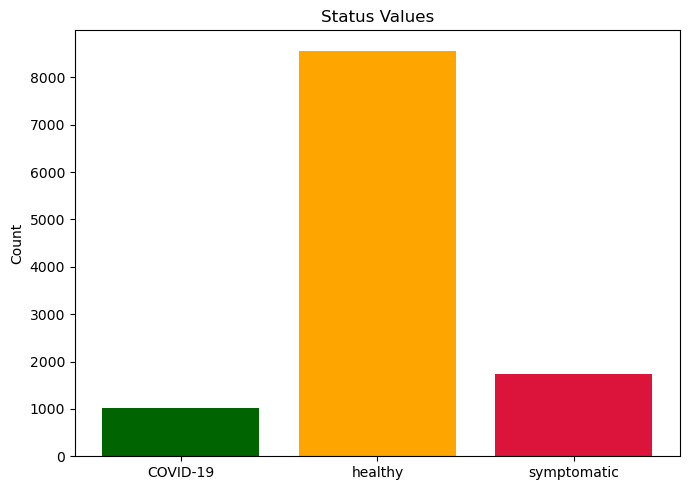

Counts: Counter({'healthy': 8562, 'symptomatic': 1742, 'COVID-19': 1010})


In [3]:
import pathlib
import matplotlib.pyplot as plt
from collections import Counter

status_counter = Counter()
ids = []

with open(labelled_ids_csv, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        ids.append(row["id"])

for entry_id in ids:
    json_file = dataset_path / f"{entry_id}.json"
    
    if not json_file.exists():
        print(f"JSON missing for: {entry_id}")
        continue

    try:
        with open(json_file, "r", encoding="utf-8") as f:
            data = json.load(f)

            status_value = str(data["status"]).strip()
            status_counter[status_value] += 1

    except Exception as e:
        print(f"Error reading {json_file}: {e}")

# ---- Plot results ----
labels = ["COVID-19", "healthy", "symptomatic"]
counts = [status_counter[label] for label in labels]

colors = ["darkgreen", "orange", "crimson"]

plt.figure(figsize=(7, 5))
plt.bar(labels, counts, color = colors)
plt.ylabel("Count")
plt.title("Status Values")
plt.tight_layout()
plt.show()

print("Counts:", status_counter)


In [4]:
#Healthy status majorly outnumbers the other classes, will apply undersampling and randomly select ~1500 entries to match symptomatic/covid cases
import random

output_csv = pathlib.Path("D:/Data Repositories/balanced_ids.csv")

healthy_n = 2000

healthy_ids = []
symptomatic_ids = []
covid_ids = []

ids = []
with open(labelled_ids_csv, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        ids.append(row["id"])

# ---- Categorize by status ----
for entry_id in ids:
    json_file = dataset_path / f"{entry_id}.json"

    if not json_file.exists():
        continue

    try:
        with open(json_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        if "status" not in data or not data["status"]:
            continue

        status = str(data["status"]).strip()

        if status == "healthy":
            healthy_ids.append(entry_id)
        elif status == "symptomatic":
            symptomatic_ids.append(entry_id)
        elif status == "COVID-19":
            covid_ids.append(entry_id)

    except Exception as e:
        print(f"Error reading {json_file}: {e}")

random.seed(42) 
healthy_sample = random.sample(healthy_ids, healthy_n)

balanced_ids = healthy_sample + symptomatic_ids + covid_ids

with open(output_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["id"])
    for entry_id in balanced_ids:
        writer.writerow([entry_id])
        
print("Balanced IDs saved to:", output_csv)


Balanced IDs saved to: D:\Data Repositories\balanced_ids.csv


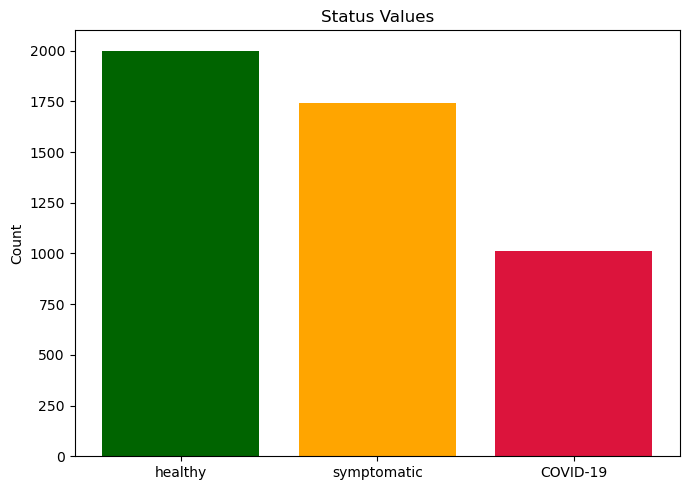

Counts: Counter({'healthy': 2000, 'symptomatic': 1742, 'COVID-19': 1010})


In [5]:
import pathlib
import matplotlib.pyplot as plt
from collections import Counter

status_counter = Counter()
ids = []

balanced_ids_csv = "D:/Data Repositories/balanced_ids.csv"


with open(balanced_ids_csv, "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        ids.append(row["id"])

for entry_id in ids:
    json_file = dataset_path / f"{entry_id}.json"
    
    if not json_file.exists():
        print(f"JSON missing for: {entry_id}")
        continue

    try:
        with open(json_file, "r", encoding="utf-8") as f:
            data = json.load(f)

            status_value = str(data["status"]).strip()
            status_counter[status_value] += 1

    except Exception as e:
        print(f"Error reading {json_file}: {e}")

labels = ["healthy", "symptomatic", "COVID-19"]
counts = [status_counter[label] for label in labels]

colors = ["darkgreen", "orange", "crimson"]

plt.figure(figsize=(7, 5))
plt.bar(labels, counts, color = colors)
plt.ylabel("Count")
plt.title("Status Values")
plt.tight_layout()
plt.show()

print("Counts:", status_counter)
#balanced_ids_csv will be used to train our svm ona 